In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 

In [2]:
np.random.seed(7)
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [3]:
dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])

dataset = dataset.reindex(index = dataset.index[::-1])

print(dataset)

        Open    High     Low   Close
1663   46.52   47.18   46.41   47.08
1662   47.49   47.50   46.88   47.33
1661   47.08   47.76   47.07   47.71
1660   47.82   47.89   47.56   47.68
1659   47.71   48.05   47.41   48.02
...      ...     ...     ...     ...
4     157.06  158.92  156.67  158.81
3     158.60  161.83  158.27  160.08
2     159.26  161.27  159.11  161.06
1     159.90  160.00  154.63  155.32
0     156.60  158.57  156.07  157.48

[1664 rows x 4 columns]


In [4]:
obs = np.arange(1, len(dataset) + 1, 1)
obs

array([   1,    2,    3, ..., 1662, 1663, 1664])

In [5]:
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

In [6]:
# plt.figure(figsize=(10,5))
# plt.subplot(1,3,1)
# plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
# plt.legend(loc = 'upper right')
# plt.subplot(1,3,2)
# plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
# plt.legend(loc = 'upper right')
# plt.subplot(1,3,3)
# plt.plot(obs, close_val, 'g', label = 'Closing price')
# plt.legend(loc = 'upper right')
# plt.show()

In [7]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
print(OHLC_avg)

[[0.01530745]
 [0.0196717 ]
 [0.02058364]
 ...
 [1.        ]
 [0.97644172]
 [0.97398819]]


In [8]:
from sklearn.model_selection import train_test_split
X_test, y_test = train_test_split(OHLC_avg, test_size=0.25, random_state=7)

In [9]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [10]:
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)
print(trainX.shape)

(1246, 1)


In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [12]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [13]:
callback  = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0001, patience=5, verbose=0,restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer='adam' , metrics='mse') # Try SGD, adam, adagrad and compare!!!
history =  model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
1246/1246 - 10s - loss: 0.0106 - mse: 0.0106
Epoch 2/5
1246/1246 - 7s - loss: 2.7876e-04 - mse: 2.7876e-04
Epoch 3/5
1246/1246 - 6s - loss: 1.7424e-04 - mse: 1.7424e-04
Epoch 4/5
1246/1246 - 6s - loss: 1.6410e-04 - mse: 1.6410e-04
Epoch 5/5
1246/1246 - 7s - loss: 2.0221e-04 - mse: 2.0221e-04


In [14]:
print(history.history.keys())

dict_keys(['loss', 'mse'])


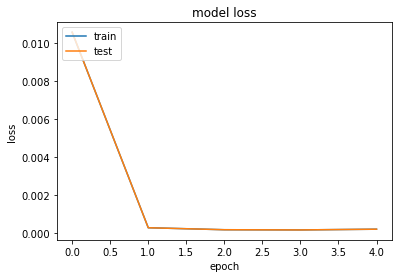

In [15]:
plt.plot(history.history['mse'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [17]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE:', trainScore)
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE:' ,testScore)
##with :- adagrad
# Train RMSE: 21.64312258115479
# Test RMSE: 35.20471461322284
##with = adam
# Train RMSE: 1.7472271658212648
# Test RMSE: 1.9381493634713887
## SGD
# Train RMSE: 22.228480200434067
# Test RMSE: 36.99967284492549


Train RMSE: 1.5800164616730106
Test RMSE: 2.9055231349231945


In [19]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [20]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [21]:
print('OG',OHLC_avg)
OHLC_avg = scaler.inverse_transform(OHLC_avg)
print(OHLC_avg)

[[0.01530745]
 [0.0196717 ]
 [0.02058364]
 ...
 [1.        ]
 [0.97644172]
 [0.97398819]]
[[ 46.7975]
 [ 47.3   ]
 [ 47.405 ]
 ...
 [160.175 ]
 [157.4625]
 [157.18  ]]


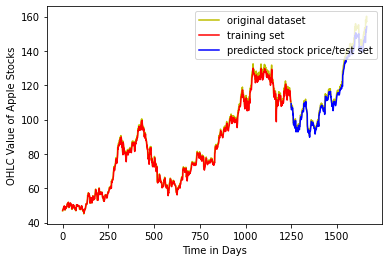

In [22]:
plt.plot(OHLC_avg, 'y', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [23]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))

Last Day Value: 154.16879272460938
Next Day Value: 146.12667846679688


<ipython-input-23-a3575500764a>:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
<ipython-input-23-a3575500764a>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))
